# Preparando os dados

In [1]:
#Conecta o ambiente ao seu google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil

#Diretório base dos dados
dir_base = Path('/content/drive/My Drive/dataset')

#Nome das classes dentro do dataset
classes = ['Carro', 'Arvore']

#Cria diretórios para treino, validação e teste dentro da pasta 'dataset'
for i in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(dir_base / i / cls, exist_ok=True)

In [3]:
#Função para dividir os dados
def divide_dados(dir_src, dir_dest, split_ratio):
    #Lista todas as imagens no diretório de origem
    arquivos = [f for f in os.listdir(dir_src) if f.lower().endswith(('jpg', 'jpeg', 'png', 'ppm', 'bmp', 'pgm', 'tif', 'tiff', 'webp'))]
    #Divide os arquivos em conjuntos de treino e validação/teste
    arquivos_treino, arquivos_val_teste = train_test_split(arquivos, test_size = split_ratio[1] + split_ratio[2])
    #Divide o conjunto de validação/teste em conjuntos de validação e teste
    val_files, test_files = train_test_split(arquivos_val_teste, test_size = split_ratio[2] / (split_ratio[1] + split_ratio[2]))

    #Copia os conjuntos de arquivos para seus respectivos diretórios
    for file in arquivos_treino:
        shutil.copy(dir_src / file, dir_dest / 'train' / dir_src.name / file)
    for file in val_files:
        shutil.copy(dir_src / file, dir_dest / 'val' / dir_src.name / file)
    for file in test_files:
        shutil.copy(dir_src / file, dir_dest / 'test' / dir_src.name / file)

Execute apenas 1 vez o código seguinte!

In [4]:
#Divide os dados (70% para treino, 20% para validação e 10% para teste)
split_ratio = [0.7, 0.2, 0.1]
for cls in classes:
    divide_dados(dir_base / cls, dir_base, split_ratio)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

#Transformações/Nomralizações de dados
#Fonte: https://www.youtube.com/watch?v=8etkVC93yU4
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
#Diretório inicial dos dados
data_dir = '/content/drive/My Drive/dataset'
#Cria o datasets de imagens e aplica as transformações nas imagens
imagem_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
#Cria dataloaders para carregar os dados em mini-batchs durante o treinamento
dataloaders = {x: torch.utils.data.DataLoader(imagem_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
#Calcula os tamanhos dos datasets
dataset_sizes = {x: len(imagem_datasets[x]) for x in ['train', 'val', 'test']}
#Obtém os nomes das classes
class_names = imagem_datasets['train'].classes

In [7]:
#Usará a GPU se disponível, caso contrário, usará a CPU para as execuções
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Treinamento dos modelos

In [8]:
#Função para treinar os modelos
#Fonte: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

In [9]:
#Carrega o modelo pré-treinado AlexNet e modifica a última camada (Finetuning)
#Fonte: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 148MB/s]


In [10]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
#Treina o modelo AlexNet
alexnet = train_model(alexnet, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1843 Acc: 0.9135
val Loss: 0.0070 Acc: 0.9926

Epoch 1/4
----------
train Loss: 0.0322 Acc: 0.9916
val Loss: 0.0042 Acc: 1.0000

Epoch 2/4
----------
train Loss: 0.0400 Acc: 0.9873
val Loss: 0.0047 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.0214 Acc: 0.9916
val Loss: 0.0101 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.0319 Acc: 0.9937
val Loss: 0.0030 Acc: 1.0000



In [12]:
#Salva o modelo AlexNet no google drive
alexnet_dir = '/content/drive/My Drive/AlexNet.pth'
torch.save(alexnet.state_dict(), alexnet_dir)

In [13]:
#Carrega o modelo pré-treinado GoogLeNet e modifica a última camada (Finetuning)
#Fonte: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
googlenet = models.googlenet(pretrained=True)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, len(class_names))
googlenet = googlenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 137MB/s]


In [14]:
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [15]:
#Treina o modelo GoogLeNet
googlenet = train_model(googlenet, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6335 Acc: 0.6456
val Loss: 0.4054 Acc: 0.9853

Epoch 1/4
----------
train Loss: 0.3360 Acc: 0.9684
val Loss: 0.1833 Acc: 1.0000

Epoch 2/4
----------
train Loss: 0.2030 Acc: 0.9620
val Loss: 0.1004 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.1386 Acc: 0.9852
val Loss: 0.0621 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.0862 Acc: 0.9937
val Loss: 0.0430 Acc: 1.0000



In [16]:
#Salva o modelo GoogleNet no google drive
googlenet_dir = '/content/drive/My Drive/GoogLeNet.pth'
torch.save(googlenet.state_dict(), googlenet_dir)

#Avaliação dos modelos

In [17]:
from sklearn.metrics import classification_report

#Função para avaliar um modelo treinado no conjunto de dados de teste
def avaliar_modelo(modelo):
    # Set the model to evaluation mode. This disables dropout layers and uses running statistics for batch normalization.
    modelo.eval()

    # Initialize lists to store true labels and predicted labels
    all_labels = []
    all_preds = []

    # Disable gradient calculation to save memory and computations
    with torch.no_grad():
        # Loop over the test dataset
        for inputs, labels in dataloaders['test']:
            # Move inputs and labels to the device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get model outputs for the inputs
            outputs = modelo(inputs)
            # Get the predicted class by finding the index of the maximum value in the outputs
            _, preds = torch.max(outputs, 1)

            # Convert the labels and predictions to numpy arrays and add them to the lists
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Return the true labels and predicted labels
    return all_labels, all_preds

In [18]:
#Avalia o AlexNet
y_true, y_pred = avaliar_modelo(alexnet)
print("AlexNet Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

AlexNet Classification Report:
              precision    recall  f1-score   support

      Arvore       1.00      1.00      1.00        35
       Carro       1.00      1.00      1.00        35

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



In [19]:
#Avalia o GoogLeNet
y_true, y_pred = avaliar_modelo(googlenet)
print("GoogLeNet Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

GoogLeNet Classification Report:
              precision    recall  f1-score   support

      Arvore       1.00      1.00      1.00        35
       Carro       1.00      1.00      1.00        35

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



#Classificação de imagens

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

#Função para carregar e pré-processar a imagem
def process_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image

#Função para classificar a imagem usando um dos modelos
def classify_image(model, image_path):
    model.eval()
    image = process_image(image_path)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        class_idx = preds.item()
        class_name = class_names[class_idx]

    return class_name

In [ ]:
#Caminho da imagem a ser classificada
image_path = '/content/drive/My Drive/testes/20240531_163406.jpg'

In [ ]:
#Classifica a imagem usando AlexNet
class_name_alexnet = classify_image(alexnet, image_path)
print(f'Classificação usando AlexNet: {class_name_alexnet}')

Classificação usando AlexNet: Carro


In [ ]:
#Classifica a imagem usando GoogLeNet
class_name_googlenet = classify_image(googlenet, image_path)
print(f'Classificação usando GoogLeNet: {class_name_googlenet}')

Classificação usando GoogLeNet: Carro


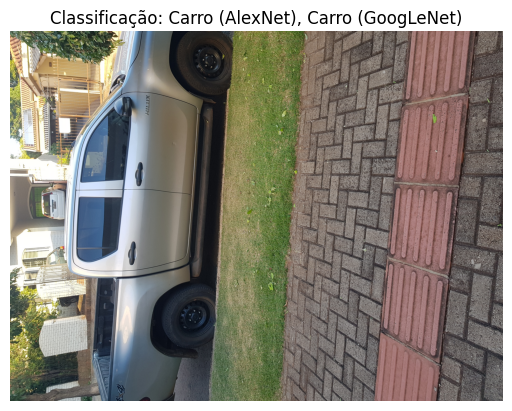

In [ ]:
#Exibe a imagem e as classificações dadas pelos dois modelos
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Classificação: {class_name_alexnet} (AlexNet), {class_name_googlenet} (GoogLeNet)')
plt.axis('off')
plt.show()